In [74]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

np.random.seed(42)

In [75]:
# Carico il dataset con le features
df = pd.read_csv('features.csv')

# Inserisco in ciascuna riga del dataframe delle features i pesi ottimi (scaricati nel file get_portfolio_weights.ipynb) della settimana successiva (che saranno la variabile da predire)
next_week_optimal_weights= pd.read_csv("df_optimal_weights.csv")
next_week_optimal_weights = next_week_optimal_weights.rename(columns=lambda x: "next_week_opt_weight_" + x)
next_week_optimal_weights= next_week_optimal_weights[1:].copy()
next_week_optimal_weights.loc[len(next_week_optimal_weights)+1] = [np.nan] * next_week_optimal_weights.shape[1]
next_week_optimal_weights.index = pd.RangeIndex(start=0, stop=len(next_week_optimal_weights), step=1)
df= pd.concat([df, next_week_optimal_weights], axis=1)
df = df.dropna()

In [76]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Input
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error

# Definisco la finestra di osservazione
window_size = 4

# Separo le colonne di input e da quelle target
data_inputs = df.iloc[:, :-5]
data_weights = df.iloc[:, -5:]

# Normalizzo i dati di input
scaler = MinMaxScaler()
data_inputs_scaled = scaler.fit_transform(data_inputs)
data_combined_scaled = np.concatenate((data_inputs_scaled, data_weights.values), axis=1)

# Creo la funzione per creare le sequenze temporali
def create_sequences(data, window_size):
    X = []
    y = []
    for i in range(len(data) - window_size):
        X.append(data[i:i + window_size, :-5])
        y.append(data[i + window_size - 1, -5:])
    return np.array(X), np.array(y)

# Creo le sequenze
X, y = create_sequences(data_combined_scaled, window_size)

# Divido dati in train e test set
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size= 0.698, shuffle=False)

lstm_units= [50, 100, 150, 200]
activation_functions= ["tanh", "sigmoid", "relu"]
epochs= [50, 100, 150]
best_parameters= {"lstm_units": 0, "activation_functions": "", "epochs": 0}
best_mse= 0
best_y_pred= []

for units in lstm_units:
    for activation_function in activation_functions:
        for n in epochs:

            #Costruisco modello LSTM
            model = Sequential()
            model.add(Input(shape=(window_size, X_train.shape[2])))
            model.add(LSTM(units, activation=activation_function))
            model.add(Dense(5, activation='softmax'))  # softmax garantisce che la somma dei pesi sia 1 e che siano non negativi

            model.compile(optimizer='adam', loss='mean_squared_error')

            # Addestro il modello
            early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
            history = model.fit(X_train, y_train, epochs=n, validation_data=(X_test, y_test), callbacks=[early_stopping], verbose= 0)

            # Previsione sui dati di test
            y_pred = model.predict(X_test)

            # Calcolo MSE
            mse = mean_squared_error(y_test, y_pred)

            if best_mse == 0:
                best_mse= mse
                best_parameters["lstm_units"]= units
                best_parameters["activation_functions"]= activation_function
                best_parameters["epochs"]= n
                best_y_pred= y_pred
            elif mse < best_mse:
                best_mse= mse
                best_parameters["lstm_units"]= units
                best_parameters["activation_functions"]= activation_function
                best_parameters["epochs"]= n
                best_y_pred= y_pred


print(f"Best parameters: {best_parameters}")
print(f"Best mse: {best_mse}")


5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 454ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 448ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 163ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 84ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 107ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 375ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 167ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 153ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 89ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 89ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 86ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 106ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 299ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 95ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 104ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 132ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 289ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 164ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 186ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 105ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 95ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 86ms

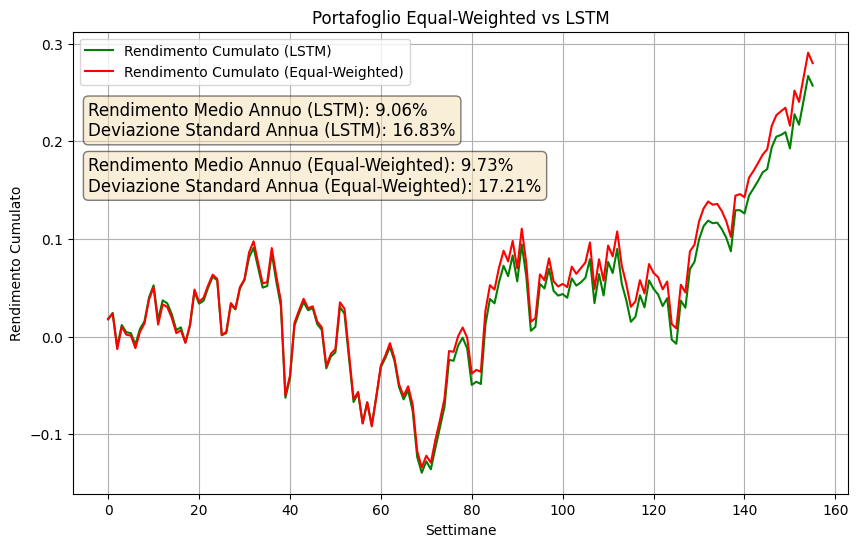

In [78]:
# Importo le funzioni che calcolano le performance di un portafoglio
from portfolio_performance_functions import get_weekly_returns, calculate_portfolio_performance, compare_portfolio_performance

weekly_returns= get_weekly_returns(pd.read_csv("stocks_data_adj_close.csv"))
compare_portfolio_performance(weekly_returns[int(len(weekly_returns) * 0.7):], best_y_pred,  pd.read_csv("df_equally_weighted_portfolio_weights.csv").to_numpy()[int(len(weekly_returns) * 0.7):], plot_title="Portafoglio Equal-Weighted vs LSTM", savefig_name="lstm_results.png", nome_p1= "Equal-Weighted", nome_p2= "LSTM")